### 참고

- 넷플릭스
    - 슬로건 : 모든것이 추천이다
    - https://netflixtechblog.com/55838468f429
    - 넷플릭스의 추천 알고리즘 구현에 대한 기술 블로그 공개

# 1. 연구 목표

- 사용자 평점 데이터를 기반으로 사용자를 특정을 예측하여 추천 시스템을 구축한다
- 실제 OTT나 쇼핑몰에서 회원가입시 추천 알고리즘으로 사용된다
- 회귀 처리, 회귀 평가, 추천시스템에 대한 이해
- FastFM(thrid party 알고리즘 사용-> 인수분해머신 기능 지원)
    - 윈도우에서 컴파일 후 설치가 불가하므로, 리눅스에 설치하여 개발을 진행

# 2. 데이터 수집, 확보

- ml-100k.zip 파일 제공
- 영화 정보 데이터
    - 고객 정보 : u.user
    - 영화 정보
    
    - 평점 정보

In [1]:
import pandas as pd

In [2]:
# u.user 라는 데이터에 컬럼이 없다보니 첫번째 데이터가 컬럼이 되었다.
# 이를 예방하기 위해서 컬럼을 지정해준다.
cols =['uid','age','m','job','zip_code']
users = pd.read_csv('./table/ml-100k/u.user', sep='|', names=cols)
users.head(2)

,uid,age,m,job,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043


In [3]:
users.tail


(2)

2

In [4]:
# 고객 943명의 데이터
users.shape

(943, 5)

In [5]:
# 영화 정보 로드
m_cols =['mid','title','release_date','video_release_date','imbd_url']
# 영어권이면 utf-8에서 오류나면 latin1으로 사용
# 원본 데이터의 컬럼이 많은데 부분만 쓰고싶다면 usecols 를 적용
movies = pd.read_csv('./table/ml-100k/u.item', sep='|', encoding='latin1', names=m_cols, usecols=range(5))
movies.head(2)

,mid,title,release_date,video_release_date,imbd_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...


In [6]:
movies.shape

(1682, 5)

In [7]:
movies.tail(2)

,mid,title,release_date,video_release_date,imbd_url
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...


In [8]:
# 평점 정보 로드 : u.data
r_cols =['uid','mid','rating','unix_timestamp']
ratings = pd.read_csv('./table/ml-100k/u.data', sep='\t', names=r_cols)
ratings.head(2)

,uid,mid,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742


In [9]:
ratings.tail(2)

,uid,mid,rating,unix_timestamp
99998,13,225,2,882399156
99999,12,203,3,879959583


In [10]:
ratings.shape

(100000, 4)

In [11]:
ratings.unix_timestamp

0        881250949
1        891717742
2        878887116
3        880606923
4        886397596
           ...    
99995    880175444
99996    879795543
99997    874795795
99998    882399156
99999    879959583
Name: unix_timestamp, Length: 100000, dtype: int64

In [12]:
# unix_timestamp 는 1970년 1월 1일 00시 00분 00초 부터 현재까지 경과된 시간
# 그래서 현재 시간, 특정시간을 특정하기가 어렵다 -> 해석이 어렵다 -> 시간형식을 변경한다
ratings['date'] = pd.to_datetime( ratings.unix_timestamp, unit='s' )

In [13]:
ratings.head(2)

,uid,mid,rating,unix_timestamp,date
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22


In [14]:
# 3. 데이터 준비, 품질향상, 전처리

In [15]:
# 4. 데이터분석 (통계,시각화)

In [16]:
# 평점과 영화 데이터 합치기
# 합친 결과 => (10000,9)
# merge를 수행할 때 중복되는 컬럼은 생략하면 알아서 찾아서 수행된다
# 단, 컬럼이 2개 이상이면 검토가 필요하다
movies_ratings = pd.merge(movies, ratings)

In [17]:
movies_ratings.shape

(100000, 9)

In [18]:
movies_ratings.head(3)

,mid,title,release_date,video_release_date,imbd_url,uid,rating,unix_timestamp,date
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,287,5,875334088,1997-09-27 04:21:28
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,148,4,877019411,1997-10-16 16:30:11


In [19]:
# movies_ratings, users  합치기
movies_lens = pd.merge(movies_ratings , users)

In [20]:
movies_lens.shape

(100000, 13)

In [21]:
movies_lens.head(10)

,mid,title,release_date,video_release_date,imbd_url,uid,rating,unix_timestamp,date,age,m,job,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,1998-02-17 17:51:30,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,1998-02-17 18:20:08,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,1998-02-17 18:07:27,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,1998-02-17 17:31:36,60,M,retired,95076
5,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,308,4,887737194,1998-02-17 17:39:54,60,M,retired,95076
6,11,Seven (Se7en) (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Se7en%20(1995),308,5,887737837,1998-02-17 17:50:37,60,M,retired,95076
7,12,"Usual Suspects, The (1995)",14-Aug-1995,NaN,http://us.imdb.com/M/title-exact?Usual%20Suspe...,308,5,887737243,1998-02-17 17:40:43,60,M,retired,95076
8,15,Mr. Holland's Opus (1995),29-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Mr.%20Holland...,308,3,887739426,1998-02-17 18:17:06,60,M,retired,95076
9,17,From Dusk Till Dawn (1996),05-Feb-1996,NaN,http://us.imdb.com/M/title-exact?From%20Dusk%2...,308,4,887739056,1998-02-17 18:10:56,60,M,retired,95076


- 데이터를 모두 병합하였다. 평점이나 회원을 중심으로 중복적인 데이터가 많다
- 데이터가 적으면 크게 문제 없으나, 크면 메모리를 많이 사용할 수도 있다(검토)

In [22]:
# 평가를 가장 많이 받은 영화 상위 10개를 출력하시오
# mid 나 title 둘 다 사용이 가능하나 결과를 이해하기 위해서 title 사용
movies_lens.title.value_counts()[:10]

Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: title, dtype: int64

In [23]:
# 평점을 받은 횟수가 적은 경우, 우현히 평점이 좋을 수도 있다.
# 따라서 데이터를 조정할때 특정횟수(임계치) 이상 평가한 작품만 고려한다.
movies_lens.title.value_counts()[-10:]

Century (1993)                                1
Someone Else's America (1995)                 1
Nobody Loves Me (Keiner liebt mich) (1994)    1
Wedding Bell Blues (1996)                     1
Man from Down Under, The (1943)               1
Love Is All There Is (1996)                   1
Nemesis 2: Nebula (1995)                      1
Small Faces (1995)                            1
Every Other Weekend (1990)                    1
Ripe (1996)                                   1
Name: title, dtype: int64

- 제목 기준으로 데이터를 분류
- 평가의 개수, 평균평점이 들어가있는 DF 
- 인덱스 : title, 컬럼 : 개수, 평균평점 <= 만드는 과정에서 컬럼의 레벨이 1이상이 되도 관계없음

In [24]:
import numpy as np

In [25]:
# groupby(컬럼) : 해당 컬럼이 인덱스로 이동
# agg ({컬럼 : [값 처리 함수..]}) : 컬럼에 처리함수 개수대로 설정되서 값이 자동 처리
movie_state = movies_lens.groupby('title').agg( {'rating':[np.size, np.mean]} )
movie_state.head(2)

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000

In [26]:
# 이 케이스에서는 피벗의 표현이 더 복잡할 수 있어서 배제하고 groupby 사용
# movie_lens.pivot_table()

- 평점을 받은 개수가 1개인 경우, 소수의 평가를 받은 영화
- 평균의 수가 적으면 잡음의 개입이 여지가 많다
- 100건 기준으로 100개 이상만 대상으로 처리 (임계값)

In [27]:
# 차후 변경함으로써 성능을 다르게 낼 수 있다
limit_std_value = 100
condition       = movie_state['rating']['size'] >= limit_std_value
condition[:2]

title
'Til There Was You (1997)    False
1-900 (1994)                 False
Name: size, dtype: bool

In [28]:
# 불리언 인덱싱
movie_state[condition]

rating          
                                               size      mean
title                                                        
101 Dalmatians (1996)                           109  2.908257
12 Angry Men (1957)                             125  4.344000
2001: A Space Odyssey (1968)                    259  3.969112
Absolute Power (1997)                           127  3.370079
Abyss, The (1989)                               151  3.589404
...                                             ...       ...
Willy Wonka and the Chocolate Factory (1971)    326  3.631902
Wizard of Oz, The (1939)                        246  4.077236
Wrong Trousers, The (1993)                      118  4.466102
Young Frankenstein (1974)                       200  3.945000
Young Guns (1988)                               101  3.207921

[338 rows x 2 columns]

In [29]:
# 정렬 -> 평균 내림차순으로 정렬하여 상위 5개만 출력
# 컬럼 레벨이 n 차 인 경우 정렬하는방법
tmp = movie_state[condition].sort_values( by = [ ('rating', 'mean' ) ] , ascending = False )
tmp.head(5)

rating          
                                   size      mean
title                                            
Close Shave, A (1995)               112  4.491071
Schindler's List (1993)             298  4.466443
Wrong Trousers, The (1993)          118  4.466102
Casablanca (1942)                   243  4.456790
Shawshank Redemption, The (1994)    283  4.445230

In [30]:
# 영화 1682개 중에서 임계값을 통과한 대상은 338개이다
# 이를 통해서 평점을 적게 받은 영화의 통계적인 추정도 가능하다

tmp.shape, movies.shape

((338, 2), (1682, 5))

In [31]:
# 간단한 시각화
# 영화별 평점의 개수 : x 축
# 평가 횟수 : y 축
from matplotlib import pyplot as plt

%matplotlib inline

'\nStar Wars (1977)                 583\n스타워즈 1977년 작품에 평가가 583회가 수행되었는데, 이중에는 이 영화만 평가한 유저도 다수 존재한다.\n(현 데이터에서는 최저 평가회수가 사용자당 20)\n'

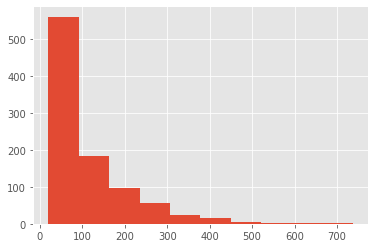

In [32]:
# 히스토그램
plt.style.use('ggplot')
movies_lens.groupby('uid').size().sort_values(ascending = False).hist()
# 사용자의 평가 횟수에 대한 성향
# 빈도가 점점 낮아진다 -> 오른쪽으로 길게 꼬리를 늘어트리는 모양 -> 롱테일 분포
# '지프의법칙' 을 따른 굴곡 모양이다
# 영화의 평가가 많으면 그 사용자들 중에는 1회성 평가 횟수도 많다
"""
Star Wars (1977)                 583
스타워즈 1977년 작품에 평가가 583회가 수행되었는데, 이중에는 이 영화만 평가한 유저도 다수 존재한다.
(현 데이터에서는 최저 평가회수가 사용자당 20)
"""

In [33]:
movies_lens.groupby('uid').size().sort_values(ascending = False)

uid
405    737
655    685
13     636
450    540
276    518
      ... 
36      20
34      20
685     20
441     20
202     20
Length: 943, dtype: int64

In [34]:
# 사용자별 평가 횟수, 평균
user_state = movies_lens.groupby('uid').agg( { 'rating':[np.size , np.mean] } )
user_state.head()

rating          
      size      mean
uid                 
1      272  3.610294
2       62  3.709677
3       54  2.796296
4       24  4.333333
5      175  2.874286

In [35]:
user_state.describe()
# 최저값: 1.49 최대 :4.67 25~75% 지점 : 3점대로 몰려있다.
# 평균 : 3.58 => 어떤 영화든지 일반적으로 3점 이상은 받는다 라고 해석할 수 있다
# 3점 이하는 영화 자체에 문제가 있어 보인다

rating            
             size        mean
count  943.000000  943.000000
mean   106.044539    3.588191
std    100.931743    0.445233
min     20.000000    1.491954
25%     33.000000    3.323054
50%     65.000000    3.620690
75%    148.000000    3.869565
max    737.000000    4.869565

### 5. 예측모델구축(머신러닝기반)

- 알고리즘 => 인수분해 머신기능을 제공하는 FastFM 이라는 모듈 사용
- FastFM
    - C++로 만들어진 libFM 이라는 알고리즘
    - libFM을 python으로 구성한 것이 FastFM
    - 기능
        - 행렬 인수 분해라는 기능을 일반화하여서 제공 -> 차원축소기법
        - 범주형 변수를 파생변수로 변환하여 범주간의 상호 작용성을 계산
        - 특징 간 영향을 주고 받은 상화 작용 개념을 계산

- FastFM 제공 알고리즘
    - ALS : 교대 최소 제곱법
        - 장점 : 예측시간 빠름 , SGD에 비해 하이퍼파라미터가 적다.
        - 단점 : 규제처리가 필요
    - SGD : 확률적 경사 하강법
        - 장점 : 예측시간 빠름 , 빅데이터를 빠르게 처리, 학습할 수 있다
        - 단점 : 하이퍼파라미터가 많다. 규제처리가 필요    
    - MCMC : 마르코프 연쇄 몬테카를로
        - 장점 : 하이퍼파라미터가 작다.
        - 단점 : 학습 시간이 느리다    

In [36]:
# 아마존 EC2 서버에 접속하였다.
# febric3를 이용하여 이하 과정을 자동화 할 수 있다

# 리눅스 상에서 루트 권한 획득
ubuntu : $ sudo su

# 리눅스의 현재 설치된 패키지등을 최신으로 업그레이드
root : $ apt-get update && apt-get -y upgrade

# 파이썬 확인
$ python3 -V
# 패키지 설치 (파이썬이 설치 되어 있으면 파이썬 부분은 제외)
$ apt-get -y install python3-dev python3-pip git nano wget unzip libopenblas-dev
# 파이썬이 있으면 이하만 설치
$ apt-get -y install python3-pip git nano wget unzip libopenblas-dev

# fastFM 소스 다운로드
$ git clone --recursive https://github.com/ibayer/fastFM.git
$ cd fastFM

# 컴파일을 수행하기 전에 python 모듈 설치
# 내용확인
$ cat requirements.txt
$ pip3 install -r ./requirements.txt

# 컴파일 -> 마지막 부분에 error가 보여도 무시
$ PYTHON=python3 make

# fastFM 설치
$ pip3 install . 

# 확인
$ python3
>>> from fastFM import als
>>> exit()

# 개발에 필요한 패키지 설치
$ pip3 install pandas matplotlib jupyter

# 옵션(삭제)
$ rm -r -f dev

# root 계정 오프
$ exit

# 작업폴더 생성
$ cd ..
$ mkdir dev && cd dev

# 주피터 가동 포트번호 기본 8888
$ jupyter notebook --ip=0.0.0.0 --port=8888 --allow-root --no-browser

http://ip-172-31-34-89:8888/?token=09bf078e200b32ec34b8921392c59716eeb2c44c90e7f1da
http://52.78.7.28:8888/?token=594bfaf44f1266acffb02a0b1495423fc4a7e0edcf4adfc4 
http://ip-172-31-34-89:8888/?token=b9d4cf499acfaab0c672ff226b189a37d877b7febe4789c1


SyntaxError: invalid syntax (<ipython-input-36-fb0f8673bc73>, line 5)

- 여기서부터는 리눅스에서 운용되므로 현 파일은 종료
    - 단 리눅스 서버에서 주피터를 새로 가동했으면 토큰은 신규로 입력해야한다
    
<a href = 'http://52.78.7.28:8888'> 이동</a>

In [ ]:
# 5. 예측모델구축(머신러닝기반)

### 가상 데이터를 이용하여 기능 확인

In [37]:
from sklearn.feature_extraction import DictVectorizer
import numpy as np

In [38]:
# DictVectorizer : 문자열만 벡터화 처리
v = DictVectorizer()

In [39]:
# 더미 데이터
# 사용자 ID, 사용자가 평가한 영화 ID, 사용자의 나이
train = [
    {'uid':'1','mid':'5','age':19},
    {'uid':'2','mid':'55','age':33},
    {'uid':'3','mid':'20','age':55},
    {'uid':'4','mid':'10','age':20}
]

In [42]:
X = v.fit_transform( train )
# 수치는 그대로 배치, 문자열이 들어간 데이터는 벡터화로 처리
# 문자열은 범주형으로 보고 해당 케이스별로 배치하여 0 혹은 1로 표시
X.toarray()

array([[19.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.],
       [33.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.],
       [55.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.],
       [20.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [43]:
# ALS를 이용하여서 처리
from fastFM import als
from sklearn.model_selection import learning_curve

In [44]:
# 더미데이터 중 20살인 유저 1번은 영화 5번에 평점을 5.0을 부여했다
# 유저별로 부여한 평점
y = np.array( [5.0, 1.0, 2.0, 4.0] )

In [45]:
# ALS를 이용하여 fastFM의 회귀모델을 초기화후 학습을 진행
# 하이퍼파라미터는 임시값을 부여
fm = als.FMRegression( n_iter=1000, init_stdev=0.1 , rank=2, l2_reg_w=0.1, l2_reg_V=0.5 )
fm.fit( X, y )

FMRegression(init_stdev=0.1, l2_reg=0, l2_reg_V=0.5, l2_reg_w=0.1, n_iter=1000,
             random_state=123, rank=2)

In [46]:
# 예측
# 새로운 유저가 신규가입을 하였다 uid가 5번이 되었다.
# 나이가 24인 유저 5번이 영화 10번에 대해 내릴 평점을 예측하라
# {'uid':'5','mid':'10','age':24}
fm.predict( v.transform({'uid':'5','mid':'10','age':24}) )

array([3.60747025])

- 제공되는 데이터는 ua.base, ua.test는 훈련용과 테스트용이 구분되어있다.
- 이를 읽어서 자료구조를 만드는 형태로 처리하는 함수 구현이 필요하다

In [47]:
def loadData( fileName, path='./table/ml-100k/'):
    data = list() # 학습용 데이터 형태
    y    = list() # 답안(평점)    
    # 데이터 추출 및 구조 작업
    with open( path + fileName ) as f: # 파일오픈
        # 한줄씩 읽어서 처리
        for line in f:
            # 데이터를 한줄씩 구분해서 추출
            uid, mid, rating, ts = line.split('\t')
            # 유저아이디와 영화아이디추가
            data.append({'uid':str(uid), 'mid':str(mid)})
            # 점수 추가
            y.append( float(rating) )
    
    return data, np.array(y)

# 훈련용 데이터 획득
dev_data, y_dev = loadData( 'ua.base' )

In [48]:
len(dev_data), y_dev.shape , y_dev[:4]

(90570, (90570,), array([5., 3., 4., 3.]))

In [49]:
# 테스트용 데이터 획득
test_data, y_test = loadData( 'ua.test' )
len(test_data), y_test.shape

(9430, (9430,))

In [50]:
# 해당 함수 확장 loadData
# 평가에 참가한 유저들의 id만 모은 데이터셋 영화의 id만 모은 데이터셋
def loadDataEx( fileName, path='./table/ml-100k/'):
    data   = list() 
    y      = list() 
    # 중복데이터를 제거하는 자료구조 생성
    users  = set()
    movies = set()
    with open( path + fileName ) as f:
        for line in f:
            uid, mid, rating, ts = line.split('\t')
            data.append({'uid':str(uid), 'mid':str(mid)})
            y.append( float(rating) )
            # 평가데이터에서 uid, mid를 추가
            users.add(uid)
            movies.add(mid)
    
    return data, np.array(y), users, movies

In [51]:
# 훈련용 데이터 획득
dev_data, y_dev, dev_users, dev_movies = loadDataEx( 'ua.base' )
# 테스트용 데이터 획득
test_data, y_test, test_users, test_movies = loadDataEx( 'ua.test' )

In [52]:
# 훈련용 및 테스트용에 참가한 유저수는 동수
# 영화수는 훈련용데이터가 테스트용 데이터보다 많다
len(dev_users), len(dev_movies), len(test_users), len(test_movies)

(943, 1680, 943, 1129)

- 데이터의 벡터화 처리
- 사전에 데이터들을 수치라도 다 문자로 처리했다.
- 평점은 제외하고 uid, mid 값은 현재 문자열이다.

In [53]:
# 훈련용 데이터의 벡터화
X_dev = v.fit_transform( dev_data )
X_dev.shape

(90570, 2623)

In [54]:
# 테스트 데이터의 벡터화
X_test = v.fit_transform( test_data )
X_test.shape

(9430, 2072)

In [55]:
# 표준편차 확인 -> 회귀에서 평가지수로 쓰기위해서 -> 평균제곱근오차를 계산하려고 함
np.std( y_dev ) , np.std( y_test )

(1.1260664426539722, 1.120180145761465)

In [56]:
from sklearn.model_selection import train_test_split

# 9:1 비율 (임의설정)
# random_state  => 항상 동일하게 데이터가 섞이게 하기 위해서
X_train, X_dev_test, y_train, y_dev_test = train_test_split( X_dev , y_dev , test_size= 0.1, random_state= 42 )

In [57]:
X_train.shape , X_dev_test.shape

((81513, 2623), (9057, 2623))

- 데이터는 모두 준비되었다.
- 회귀 모델에 학습 및 예측을 수행하기위해 데이터의 형태를 알고리즘에 맞춰서 구성하였다

- 알고리즘을 선택
    - mcmc
        - 학습 및 예측 수행
        - 시각화를 통해서 수렴해가는 과정 확인
        - 테스트 데이터를 이용한 성능측정
             - 평균제곱근오차 및 손실함수를 이용하여 평가
        - 하이퍼파라미터 활용(고정) 하여 평점의 정규화처리, 성능평가
        - 기타 정보 추가

### 1월 23일 목요일

In [68]:
# 평균제곱근오차 함수
from sklearn.metrics import mean_squared_error
from fastFM import mcmc

In [69]:
# 0. 실험 수치 설정
# mcmc 의 하이퍼파라미터 및 실험 임계값 변수 지정
rank = 4
seed = 123
# 실험 임계값 변수 지정
n_iter = 300  # 반복횟수로 사용 (사용할때 확인)
step_size = 1 # 훈련시 사용되는 값

In [70]:
# 1. 알고리즘 생성
# n_iter : 샘플수 (als에서는 학습 세트의 반복 수, sgd에서는 단계)
# rank   : 인수분해의 순위
# random_state : 난수 고정 (항상 동일한 결과치를 얻기 위해 사용)
fm = mcmc.FMRegression(n_iter=0, rank=rank, random_state=seed)

In [71]:
# 2. 데이터 준비 (이미 위에서 구현)

In [72]:
# 3. 훈련 및 예측
fm.fit_predict(X_train, y_train, X_dev_test)

array([0., 0., 0., ..., 0., 0., 0.])

In [73]:
# 4. 손실함수를 구해서 어떤 값으로 수렴하는지를 확인
# 손실함수 : 정답에 가까운 오류를 수치로 표현
# 오답에 가까울 수록 값이 크다. => 정답에 가까울수록 값이 작아진다 
# 회귀모델에서 성능 평가를 처리하는 지표  => 평균제곱근오차를 통한 손실함수, 결정계수
# -> 특정 값으로 수렴한다 (나중에는 하이퍼파라미터나 다른것들을 수정해 가면서 확인)
# 구하는 방법은 평균제곱근오차함수값을 제곱근 처리하면 나온다.
# 평균제곱근오차함수의 인자값 : 예측값, 예측에 사용한 데이터의 값

In [74]:
# fm.hyper_param_ 을 담기 위해서 자료 구조를 준비
# 0 행렬을 만들어서 담는다
# 배열의 원소들은 타입이 모두 동일하다
# 데이터프레임의 원소들은 컬럼끼리만 타입이 동일하고 컬럼대 컬럼으로 보면 다를수 있다.
# rank*2 +3 = 11
hyper_param = np.zeros(( n_iter-1, rank*2+3 ), dtype=np.float64 )
hyper_param.shape

(299, 11)

In [75]:
# 구현환경은 n_iter만큼 반복하면서 수행한다
# 손실함수 값을 넣는 리스트 생성
rmse_test = list()

for nr, i in enumerate(range(1, n_iter)):   # 1, n_iter : 1~ 299 -> 0:1, 1:2, ... 298:299로 표현 : enumerate사용
    # 기준값 확인
    # print(nr, i)
    # break
    # 난수 변경 ( 학습 및 예측 수행시 훈련/ 검증 폴드의 성분이 바뀐다)
    fm.random_state = i * seed  # 1*123,2*123, ... 299*123 
    # 학습 및 예측
    y_pred = fm.fit_predict(X_train, y_train, X_dev_test, n_more_iter = step_size)
    # 손실함수 값 획득 (평가)
    loss_v = np.sqrt( mean_squared_error( y_pred , y_dev_test ))
    # 손실함수 값을 모은다
    rmse_test.append( loss_v )
    # fm.hyper_param_ <= numpy.ndarray 배열이면서 11개의 성분을 가진다. print로 확인    
    print(fm.hyper_param_, type(fm.hyper_param_))
    # hyper_param_  을 담기
    # hyper_param 는 300*11 hyper_param_은 11이다
    hyper_param[ nr, : ] = fm.hyper_param_
hyper_param   

[ 7.29936807e-02  1.01534507e+02  1.09545845e+02  1.00682624e+02
  9.07375308e+01  1.01817181e+02  1.43406954e-03 -1.17820912e-03
 -2.64130136e-04 -1.52355401e-03 -1.94369678e-03] <class 'numpy.ndarray'>
[ 8.36490856e-01  1.00123392e+02  1.05959358e+02  9.41424772e+01
  8.48872557e+01  9.63430325e+01 -1.97714841e-03 -1.57690950e-03
  6.35869726e-04 -3.12144587e-03 -2.98777035e-03] <class 'numpy.ndarray'>
[ 1.02700665e+00  3.23757929e+01  1.01870475e+02  9.20991603e+01
  8.16298813e+01  9.22876603e+01 -7.80849132e-03 -6.54788806e-03
  1.30186941e-03 -1.33292961e-03 -3.37801855e-03] <class 'numpy.ndarray'>
[ 1.11296461e+00  1.24257802e+01  1.00969880e+02  8.78492782e+01
  8.14037474e+01  8.35890933e+01 -3.60037498e-02 -4.29896035e-03
  5.23633472e-03  2.54055699e-03 -3.26100245e-03] <class 'numpy.ndarray'>
[ 1.15833652e+00  6.99396391e+00  9.90697250e+01  8.56177836e+01
  8.08977017e+01  7.68142612e+01 -5.06494647e-02  9.64403894e-04
  7.33988909e-03  6.68585270e-04  6.23401524e-04] <cla

array([[ 7.29936807e-02,  1.01534507e+02,  1.09545845e+02, ...,
        -2.64130136e-04, -1.52355401e-03, -1.94369678e-03],
       [ 8.36490856e-01,  1.00123392e+02,  1.05959358e+02, ...,
         6.35869726e-04, -3.12144587e-03, -2.98777035e-03],
       [ 1.02700665e+00,  3.23757929e+01,  1.01870475e+02, ...,
         1.30186941e-03, -1.33292961e-03, -3.37801855e-03],
       ...,
       [ 1.41530233e+00,  4.94956660e+00,  4.84472474e+00, ...,
        -1.59330595e-01, -2.75449109e-01,  1.48574867e-02],
       [ 1.40748074e+00,  5.36560318e+00,  5.02194975e+00, ...,
        -1.80935167e-01, -2.61153633e-01,  2.88644431e-03],
       [ 1.41138484e+00,  5.22930424e+00,  5.41863118e+00, ...,
        -1.47430605e-01, -2.64029678e-01,  1.06188403e-03]])

In [78]:
# 손실함수가 모여있는 자료구조
print(len( rmse_test ))
# fm.hyper_param_이 모여있는 자료구조
print(hyper_param.shape)

299
(299, 11)


In [79]:
# 시각화를 통해 값의 수렴의 추이를 살펴본다
from matplotlib import pyplot as plt

In [82]:
x = np.arange( 1,n_iter )
x.shape, x[:1], x[-1:]

((299,), array([1]), array([299]))

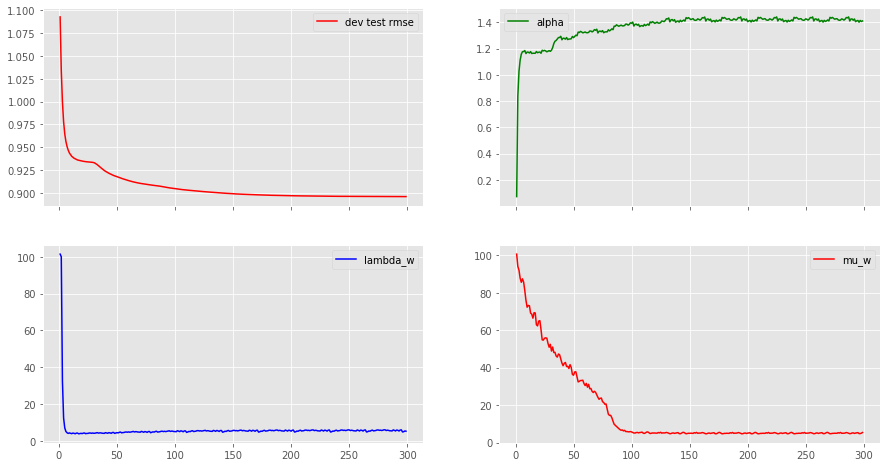

In [88]:
# 화면을 2*2 격자 모양으로 차트를 배치
fig, axes = plt.subplots( nrows=2, ncols=2, sharex=True, figsize=(15,8))

# x축은 1~299까지 학습 수행횟수
axes[0 , 0].plot( x , rmse_test, label='dev test rmse' ,color='r')
axes[0 , 0].legend()

axes[0 , 1].plot( x , hyper_param[:,0], label='alpha',color='g')
axes[0 , 1].legend()

axes[1 , 0].plot( x , hyper_param[:,1], label='lambda_w',color='b')
axes[1 , 0].legend()

axes[1 , 1].plot( x , hyper_param[:,3] ,label='mu_w',color='r')
axes[1 , 1].legend()

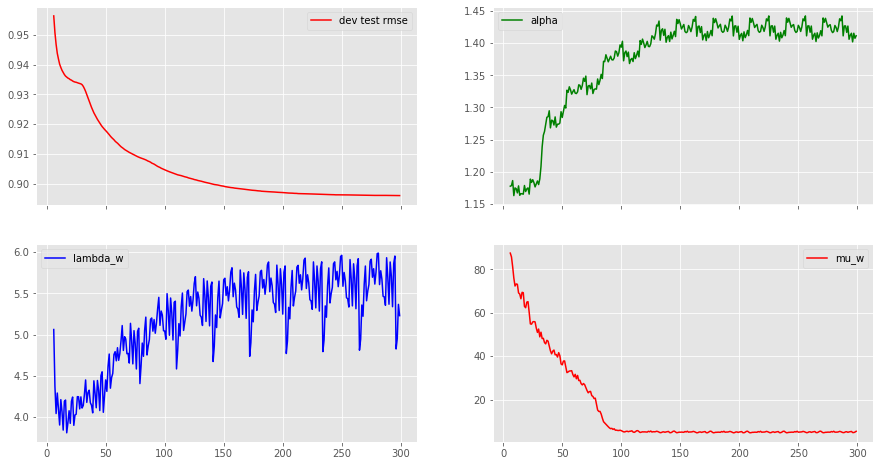

In [89]:
# 초기는 성능이 안나오는 지점이라서 그래프가 길게 보이고 세부 변화가 보이지 않는다
# 굳이 의미 없는 초기 수행 횟수는 제거하여서 차트를 좀 더 상세하게 표현하겠다
# 상위 다섯개의 데이터는 누락해서 처리 (판단근거는 세번째 그래프 lambda_w가 10정도에서 수렴하는것으로 보인다)
fig, axes = plt.subplots( nrows=2, ncols=2, sharex=True, figsize=(15,8))

# x축은 1~299까지 학습 수행횟수
skip_idx = 5
axes[0 , 0].plot( x[skip_idx:] , rmse_test[skip_idx:], label='dev test rmse' ,color='r')
axes[0 , 0].legend()

axes[0 , 1].plot( x[skip_idx:] , hyper_param[skip_idx:,0], label='alpha',color='g')
axes[0 , 1].legend()

axes[1 , 0].plot( x[skip_idx:] , hyper_param[skip_idx:,1], label='lambda_w',color='b')
axes[1 , 0].legend()

axes[1 , 1].plot( x[skip_idx:] , hyper_param[skip_idx:,3] ,label='mu_w',color='r')
axes[1 , 1].legend()

In [90]:
# 손실함수의 최소값
# 예측을 수행한 후 획득한 값 -> 최초 기준값으로 보고 이 수치보다 낮추면 성능을 향상시킨것이라고 판단할 수 있다.
np.min(rmse_test)

0.8959692745565979

- 반복횟수가 100 ~ 150번 사이로 진입을 하면 rmse값은 안정화 되어간다(수렴한다)
- 하이퍼파라미터들은 100회를 넘으면서 안정화되어간다.


In [ ]:
# 6. 시스템 통합 (서비스에 반영, OTT, 쇼핑몰 등등)